### Step 1: Import Libraries

Purpose: This step ensures all necessary Python libraries are imported for data manipulation, visualization, model training, and accessing cloud storage.

Key Note: TensorFlow emits a warning about missing CUDA drivers, indicating it will use the CPU. GPU support can improve performance significantly for deep learning.

In [4]:
#! pip install tensorflow

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from google.cloud import storage

2024-12-31 14:38:11.260995: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 14:38:11.264322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 14:38:11.273251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735655891.288667    4610 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735655891.292987    4610 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-31 14:38:11.310168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Step 2: Load Data from Google Cloud Storage

Purpose: Fetch datasets from a Google Cloud bucket to use in training and testing the CNN model.

Key Note: Ensure your Google Cloud credentials are properly set up, and the bucket contains the expected data files.
Download Required Files


In [6]:
storage_client = storage.Client()
bucket = storage_client.bucket("mnist_wells")

### Download required files

Purpose: Loop through the file dictionary to download required datasets and mapping files.

Tip: Use download_to_filename to save files locally for processing.

In [7]:
files = {
    'train': 'emnist-balanced-train.csv',
    'test': 'emnist-balanced-test.csv',
    'mapping': 'emnist-balanced-mapping.txt'
}

for name, filename in files.items():
    blob = bucket.blob(filename)
    blob.download_to_filename(f"/tmp/{filename}")

### Read the downloaded files

Purpose: Use pandas to load CSV files into DataFrame objects for data analysis and preparation.

Key Note: Ensure the correct delimiter is specified when reading the files.

In [8]:
train = pd.read_csv("/tmp/emnist-balanced-train.csv", delimiter=',')
test = pd.read_csv("/tmp/emnist-balanced-test.csv", delimiter=',')
mapping = pd.read_csv("/tmp/emnist-balanced-mapping.txt", delimiter=' ', index_col=0, header=None)


### Step 3: Split Features and Labels

Purpose: Separate the input features (images) from the output labels (classes) for both training and testing datasets.

Key Note: Double-check that the indices match the dataset's format. Shape printouts confirm the correctness of data extraction.

In [10]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

print(f"Training data shape: {train_x.shape}")
print(f"Testing data shape: {test_x.shape}")

Training data shape: (112799, 784)
Testing data shape: (18799, 784)


### Step 4: Image Preprocessing

Purpose: Normalize and rotate images for consistent input to the CNN.

Key Note: Normalize pixel values to [0, 1] by dividing by 255, which helps the model converge during training.

In [12]:
def rotate_image(image):
    """Rotate and flip image for correct orientation"""
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

# Apply rotation to all images
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate_image, 1, train_x)
test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate_image, 1, test_x)

# Normalize pixel values
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255


### Step 5: Visualize Some Training Images

Purpose: Visually inspect a subset of the dataset to confirm preprocessing steps and understand the dataset.

Key Note: Use the mapping file to decode labels into human-readable characters.

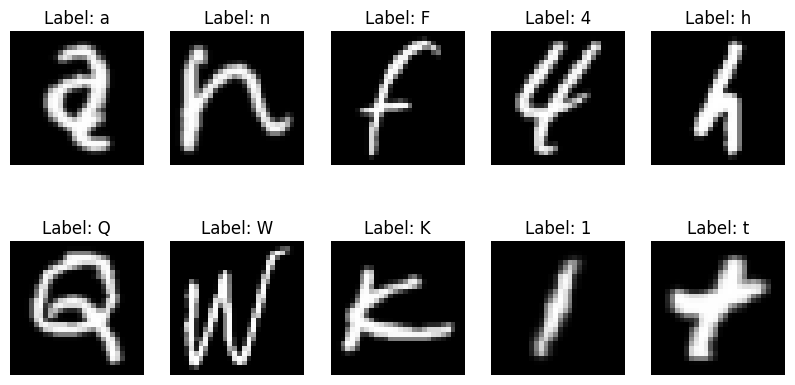

In [13]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    label = train_y.iloc[i]
    character = chr(mapping.loc[label].values[0])
    plt.title(f'Label: {character}')
    plt.axis('off')
plt.show()

# Step 6: Prepare Data for Training

Purpose: One-hot encode the labels and reshape the images to add the channel dimension for compatibility with CNN layers.

Key Note: The number of classes is derived from the mapping file to ensure consistency.

In [14]:
num_classes = len(mapping)
print(f"Number of classes: {num_classes}")

# One-hot encode labels
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

# Reshape images for CNN
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)


Number of classes: 47


### Step 7: Create Train/Validation Split

Purpose: Split the training data into training and validation sets for model evaluation.

Key Note: A test_size of 0.1 means 10% of the data is used for validation.

In [15]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)


### Step 8: Build the Model

Purpose: Define the CNN architecture with convolutional, pooling, and dense layers.

Key Note: Dropout layers help reduce overfitting by randomly deactivating neurons during training.

In [17]:
model = models.Sequential([
    # First Convolution Block
    layers.Conv2D(128, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Second Convolution Block
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-31 14:51:08.619305: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,719 (1.85 MB)

 Trainable params: 484,719 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

### Step 9: Compile the Model

Purpose: Configure the model with an optimizer, loss function, and evaluation metrics.

Key Note: Categorical cross-entropy is appropriate for multi-class classification problems.

In [18]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


### Step 10: Train the Model

Purpose: Train the model on the dataset while monitoring validation performance.

Key Note: Increase the number of epochs for better results, but balance it with training time.

In [27]:
history = model.fit(train_x, train_y,
                   validation_data=(val_x, val_y),
                   epochs=25, # Takes 1 min per Epoch so 5 is 5mins, 25 is 25mins
                   batch_size=512,
                   verbose=1)


Epoch 1/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 308ms/step - accuracy: 0.8948 - loss: 0.2686 - val_accuracy: 0.8884 - val_loss: 0.3239
Epoch 2/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.8994 - loss: 0.2614 - val_accuracy: 0.8866 - val_loss: 0.3319
Epoch 3/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.8983 - loss: 0.2604 - val_accuracy: 0.8879 - val_loss: 0.3418
Epoch 4/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 309ms/step - accuracy: 0.9005 - loss: 0.2545 - val_accuracy: 0.8852 - val_loss: 0.3425
Epoch 5/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 309ms/step - accuracy: 0.9012 - loss: 0.2535 - val_accuracy: 0.8852 - val_loss: 0.3428
Epoch 6/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 307ms/step - accuracy: 0.9037 - loss: 0.2488 - val_accuracy: 0.8861 - val_loss: 0.3466
Epoch 7/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.9016 - loss: 0.2489 - val_accuracy: 0.8879 - val_loss: 0.3454
Epoch 8/25
199/199 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step - accuracy: 0.9056 - loss: 0

### Step 11: Plot Training History

Purpose: Visualize training and validation accuracy/loss to understand the model's performance.

Key Note: Look for overfitting (validation loss increasing while training loss decreases).


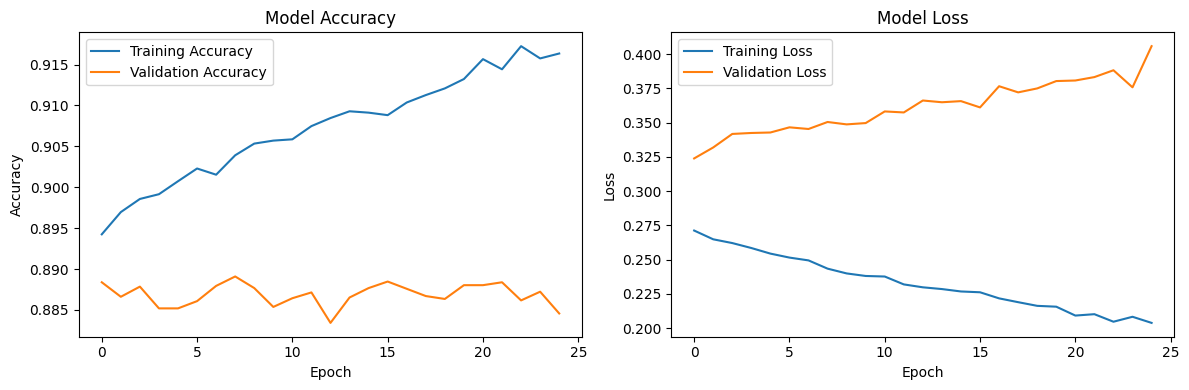

In [29]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 12: Evaluate on Test Data

Purpose: Assess the model's performance on unseen test data.

Key Note: Test accuracy is a good indicator of the model's real-world performance.


In [31]:
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

588/588 - 4s - 7ms/step - accuracy: 0.8822 - loss: 0.4447

Test accuracy: 0.8822


### Step 13: Make Predictions and Visualize Results

Purpose: Generate predictions on test samples and compare them with true labels.

Key Note: Use color-coded titles to highlight correct (green) and incorrect (red) predictions.


### Save the Model

Purpose: Save the trained model for future use or deployment.

Key Note: Consider saving in the newer .keras format for better compatibility.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


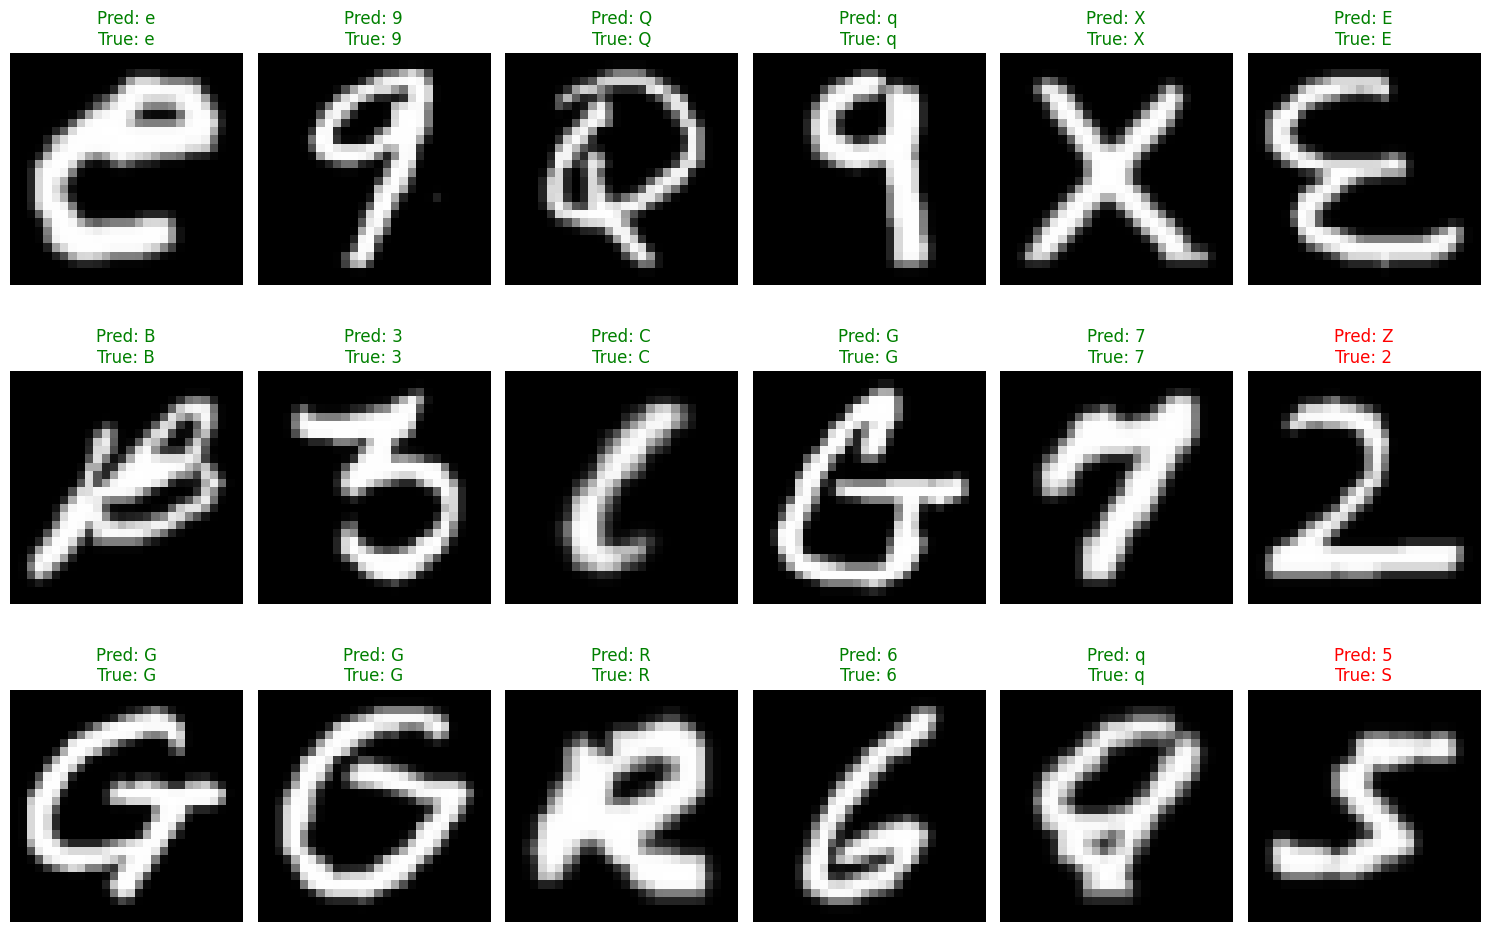

Model saved as 'emnist_model.h5'


In [32]:
predictions = model.predict(test_x[:18])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_y[:18], axis=1)

# Create label dictionary from mapping
label_dict = {index: chr(mapping.loc[index].values[0]) for index in mapping.index}

# Plot predictions
plt.figure(figsize=(15, 10))
for i in range(18):
    plt.subplot(3, 6, i+1)
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    pred_char = label_dict[predicted_labels[i]]
    true_char = label_dict[true_labels[i]]
    title = f'Pred: {pred_char}\nTrue: {true_char}'
    plt.title(title, color='green' if pred_char == true_char else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Save the model
model.save('emnist_model.h5')
print("Model saved as 'emnist_model.h5'")